Los métodos de clustering se basan en el concepto de distancia, y en consecuencia se ven extremadamente afectados por la maldición de la dimensionalidad.

Una solución es aplicar métodos de reducción de dimensiones antes de emplear métodos de clustering.

Sin embargo, aplicar un método de reducción de dimensiones sobre todas las columnas resume tanto la información útil cómo la inútil (inútil para el objetivo de aprendizaje supervisado para el que emplearemos la información posteriormente).

Por ello es importante realizar la selección de variables antes de la reducción de dimensiones, para resumir únicamente la información útil (útil para la predicción de los precios de los alquileres en Airbnb).

Por estos motivos, en esta práctica he realizado primero la selección de variables (Notebook "3- Selección de variables"), después voy a aplicar PCA a las variables seleccionadas como relevantes, y finalmente emplearé k-means sobre las primeras componentes principales para dividir las observaciones en clústeres relevantes para la predicción del precio, evitando la maldición de la dimensionalidad.

Cargo las librerías necesarias:

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from scipy.cluster.vq import kmeans, vq

Cargo los datos:

In [2]:
X_train = pd.read_csv('X_train_imputado.csv')
del X_train['Unnamed: 0']

X_test = pd.read_csv('X_test_imputado.csv')
del X_test['Unnamed: 0']

y_train = pd.read_csv('log_y_train.csv')
del y_train['Unnamed: 0']

Variables = pd.read_csv('Variables.csv')
del Variables['Unnamed: 0']
Variables['0'][0]

"'Amenities: Internet','Amenities: TV','Maximum Nights','Amenities: translation missing: en.hosting_amenity_50','Amenities: translation missing: en.hosting_amenity_49','Review Scores Communication','Amenities: Dryer','Host Response Rate','Amenities: Family/kid friendly','Review Scores Accuracy','Review Scores Checkin','Review Scores Value','Review Scores Cleanliness','Minimum Nights','Calculated host listings count','Review Scores Location','Number of Reviews','Availability 60','Host Listings Count','Host Total Listings Count','Availability 30','Review Scores Rating','Availability 90','Availability 365','Calendar Updated','Host Verifications','Extra People','Reviews per Month','Guests Included','Amenities: Air conditioning','Beds','Bathrooms','Zona','Bedrooms','Accommodates','Room Type','Cancellation Policy','Amenities: Kitchen','Amenities: Hair dryer'"

Copio y pego las variables seleccionadas como importantes en el Notebook previo "3- Selección de variables":

In [3]:
Variables = ['Amenities: Internet','Maximum Nights','Amenities: TV','Amenities: translation missing: en.hosting_amenity_50','Amenities: translation missing: en.hosting_amenity_49','Amenities: Dryer','Amenities: Family/kid friendly','Host Response Rate','Review Scores Communication','Review Scores Cleanliness','Review Scores Checkin','Minimum Nights','Review Scores Value','Review Scores Accuracy','Calculated host listings count','Number of Reviews','Review Scores Location','Host Listings Count','Availability 60','Availability 30','Availability 365','Host Total Listings Count','Availability 90','Review Scores Rating','Calendar Updated','Host Verifications','Extra People','Reviews per Month','Guests Included','Amenities: Air conditioning','Beds','Bathrooms','Zona','Bedrooms','Accommodates','Room Type','Cancellation Policy','Amenities: Hair dryer','Property Type']

Redefino los datasets X_train y X_test para que contengan sólo las variables seleccionadas en el Notebook previo:

In [4]:
X_train = X_train.loc[:,Variables]
X_test = X_test.loc[:,Variables]

## Análisis de Componentes Principales (PCA)

Estandarizo el dataset de train antes de aplicar PCA:

In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
X = scaler.transform(X_train)

Aplico PCA sobre el dataset de train:

In [6]:
pca = PCA()
principalComponents = pca.fit_transform(X)

Muestro la varianza explicada por cada componente, y la varianza acumulada explicada, en los siguientes gráficos. Seleccionaré el número de componentes principales a emplear por medio del criterio del codo:

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


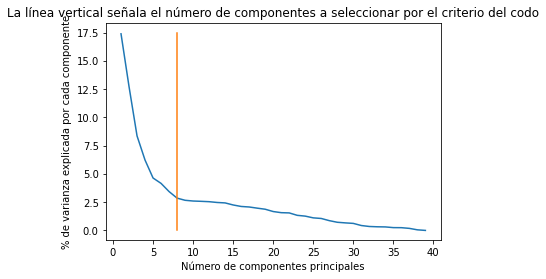

In [7]:
sns.lineplot([1+n for n in list(range(39))],100*pca.explained_variance_ratio_)
plt.xlabel("Número de componentes principales")
plt.ylabel("% de varianza explicada por cada componente")
plt.title("La línea vertical señala el número de componentes a seleccionar por el criterio del codo")
plt.plot((8, 8), (0, 17.5))
plt.show()

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


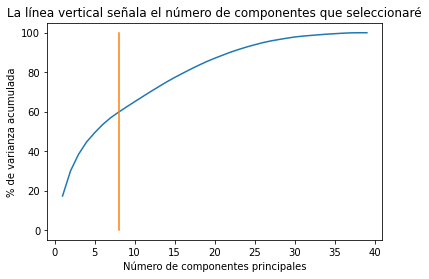

In [8]:
varianza_acumulada = []
s = 0
for n in pca.explained_variance_ratio_:
    s += n
    varianza_acumulada.append(s)
sns.lineplot([1+n for n in list(range(39))],100*np.array(varianza_acumulada))
plt.xlabel("Número de componentes principales")
plt.ylabel("% de varianza acumulada")
plt.title("La línea vertical señala el número de componentes que seleccionaré")
plt.plot((8, 8), (0, 100))
plt.show()

He seleccionado 8 como el número de componentes a emplear.

In [9]:
pca = PCA(8)
principalComponents = pca.fit_transform(X)

Añado las 8 primeras componentes principales al dataset de train, como variables adicionales:

In [10]:
P_comp = pd.DataFrame(principalComponents,
                      columns = ['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8'])

X_train = pd.concat([X_train, P_comp], axis=1)
X_train.head()

,Amenities: Internet,Maximum Nights,Amenities: TV,Amenities: translation missing: en.hosting_amenity_50,Amenities: translation missing: en.hosting_amenity_49,Amenities: Dryer,Amenities: Family/kid friendly,Host Response Rate,Review Scores Communication,Review Scores Cleanliness,...,Amenities: Hair dryer,Property Type,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8
0,1,1125,1,1,0,0,1,100.000000,10.000000,10.000000,...,1,4.029406,-2.413614,0.890887,-1.042341,-1.284525,1.724844,0.633688,0.003386,-0.145716
1,1,1125,1,0,0,1,1,91.789343,7.857012,7.205478,...,1,4.097147,2.754977,3.100605,2.480123,-2.435073,0.446193,-1.332424,1.473220,1.249746
2,1,1125,1,1,1,0,0,93.738614,7.318745,7.118343,...,0,4.029406,4.423233,-0.430230,-0.021564,2.748976,1.093471,-2.093940,-0.042655,-0.382861
3,1,1125,1,1,1,1,0,100.000000,10.000000,10.000000,...,1,4.029406,-1.995156,-1.515287,-0.099072,1.581483,0.589900,-1.260695,2.514142,1.103865
4,1,2,0,0,0,1,0,87.477680,7.762501,7.021760,...,0,4.029406,4.021199,-1.713394,1.564090,0.356303,-0.543808,-0.586949,0.021699,-1.137224


Escalo el dataset de test. Empleo para ello el algoritmo de escalado que fue entrenado en el dataset de train:

In [11]:
X_test2 = scaler.transform(X_test)

Calculo los valores de las componentes principales para cada observación del dataset de test. Lo hago con las componentes principales calculadas en el dataset de train:

In [12]:
principalComponents_test = pca.transform(X_test2)

Añado como variables al dataset de test las componentes principales (calculadas sobre train):

In [13]:
P_comp_test = pd.DataFrame(principalComponents_test,
                           columns = ['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8'])

X_test = pd.concat([X_test, P_comp_test], axis=1)
X_test.head()

,Amenities: Internet,Maximum Nights,Amenities: TV,Amenities: translation missing: en.hosting_amenity_50,Amenities: translation missing: en.hosting_amenity_49,Amenities: Dryer,Amenities: Family/kid friendly,Host Response Rate,Review Scores Communication,Review Scores Cleanliness,...,Amenities: Hair dryer,Property Type,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8
0,1,5,1,1,1,0,0,100.0,10.000000,10.000000,...,0,4.097147,-1.518044,-2.350850,1.303288,2.483469,0.508625,-1.601865,0.192628,1.151590
1,1,1125,1,1,0,0,0,100.0,7.747883,7.037765,...,0,4.029406,3.529995,-1.785904,0.406368,-0.065501,-0.069290,-1.293420,0.763692,-0.603217
2,1,1125,1,1,0,0,1,100.0,10.000000,9.000000,...,1,4.029406,-1.329243,-1.948619,-1.180420,0.053726,0.124300,0.579981,0.574137,-0.818845
3,1,1125,1,0,0,1,1,100.0,10.000000,10.000000,...,0,4.029406,-1.795185,3.558799,1.194108,0.850942,0.724087,0.948390,0.666058,0.045900
4,1,1125,1,1,1,0,0,100.0,9.000000,9.000000,...,1,4.029406,1.164492,-2.932281,2.495249,1.541437,0.889682,-1.935571,0.656157,-0.570667


Para comprobar si nuevas variables (las componentes principales) son informartivas, recurro a su Mutual Information.

In [14]:
def Información_Mutua(X, y):
    '''
    X debe ser un DataFrame con las variables predictivas.
    y debe contener la variable objetivo.
    '''
    # Calculo el mutual information,
    # y ordeno las variables según el mutual information:
    
    mi_scores = mutual_info_regression(np.array(X), y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

In [15]:
I_M = Información_Mutua(X_train, y_train)
I_M[::]

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PCA2                                                     0.374685
Room Type                                                0.369284
Accommodates                                             0.365136
Host Listings Count                                      0.247188
Host Total Listings Count                                0.244319
Calculated host listings count                           0.239002
Bedrooms                                                 0.233699
Beds                                                     0.216926
Guests Included                                          0.163020
Zona                                                     0.155554
PCA4                                                     0.147934
Bathrooms                                                0.142206
PCA5                                                     0.117088
Extra People                                             0.108867
PCA1                                                     0.108630
PCA8      

In [16]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

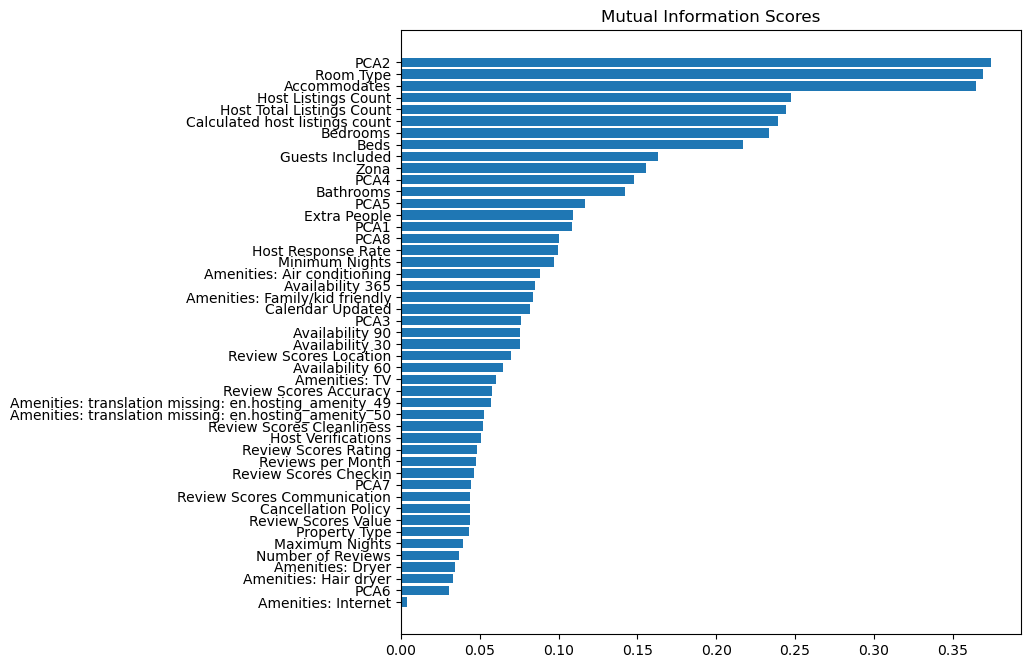

In [17]:
plt.figure(dpi=100, figsize=(8, 8))
plot_mi_scores(I_M)

Efectivamente, algunas de las componentes principales son muy informativas. En particular, la segunda componente principal es la variable más informativa.

## Feature Engineering

Los pesos de las distintas variables en la segunda componente principal, que es la más informativa, son:

In [18]:
for n in range(len(Variables)):
    print(round(pca.components_[1][n],1),Variables[n])

0.0 Amenities: Internet
0.0 Maximum Nights
0.1 Amenities: TV
-0.2 Amenities: translation missing: en.hosting_amenity_50
-0.2 Amenities: translation missing: en.hosting_amenity_49
0.1 Amenities: Dryer
0.2 Amenities: Family/kid friendly
0.0 Host Response Rate
-0.1 Review Scores Communication
-0.0 Review Scores Cleanliness
-0.1 Review Scores Checkin
0.0 Minimum Nights
-0.1 Review Scores Value
-0.1 Review Scores Accuracy
0.3 Calculated host listings count
-0.0 Number of Reviews
-0.0 Review Scores Location
0.3 Host Listings Count
-0.0 Availability 60
-0.0 Availability 30
0.0 Availability 365
0.3 Host Total Listings Count
-0.0 Availability 90
-0.1 Review Scores Rating
-0.1 Calendar Updated
0.0 Host Verifications
0.1 Extra People
-0.0 Reviews per Month
0.2 Guests Included
0.2 Amenities: Air conditioning
0.3 Beds
0.2 Bathrooms
0.1 Zona
0.3 Bedrooms
0.4 Accommodates
0.2 Room Type
0.2 Cancellation Policy
0.1 Amenities: Hair dryer
0.1 Property Type


Los términos con peso superior a 0.2 son:

In [19]:
['Amenities: translation missing: en.hosting_amenity_50',
 'Amenities: translation missing: en.hosting_amenity_49',
 'Amenities: Family/kid friendly',
 'Calculated host listings count',
 'Host Listings Count',
 'Host Total Listings Count',
 'Guests Included',
 'Amenities: Air conditioning',
 'Beds',
 'Bathrooms',
 'Zona',
 'Bedrooms',
 'Accommodates',
 'Room Type',
 'Cancellation Policy']

['Amenities: translation missing: en.hosting_amenity_50',
 'Amenities: translation missing: en.hosting_amenity_49',
 'Amenities: Family/kid friendly',
 'Calculated host listings count',
 'Host Listings Count',
 'Host Total Listings Count',
 'Guests Included',
 'Amenities: Air conditioning',
 'Beds',
 'Bathrooms',
 'Zona',
 'Bedrooms',
 'Accommodates',
 'Room Type',
 'Cancellation Policy']

Muchos de estos pesos comparten una temática muy similar, es el caso de 'Beds', 'Bathrooms', 'Bedrooms', 'Accommodates' y 'Room Type'. Creo la siguiente interacción no lineal entre estas variables:

$$(0.4*Xtrain['Accommodates']+0.3*Xtrain['Beds'])*(0.3*Xtrain['Bedrooms']+0.2*Xtrain['Bathrooms'])*Xtrain['Room Type']$$

In [20]:
X_train['PCA2_v2'] = (0.4*X_train['Accommodates']+0.3*X_train['Beds'])*(0.3*X_train['Bedrooms']+0.2*X_train['Bathrooms'])*X_train['Room Type']

Compruebo si esta interacción es informativa:

In [21]:
I_M = Información_Mutua(X_train, y_train)
I_M[::]

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PCA2_v2                                                  0.527236
Room Type                                                0.377668
PCA2                                                     0.374614
Accommodates                                             0.356086
Host Listings Count                                      0.246671
Host Total Listings Count                                0.246625
Bedrooms                                                 0.240539
Calculated host listings count                           0.239558
Beds                                                     0.215872
Zona                                                     0.170726
Guests Included                                          0.157221
PCA4                                                     0.147870
Bathrooms                                                0.144267
PCA5                                                     0.114758
PCA1                                                     0.107757
Extra Peop

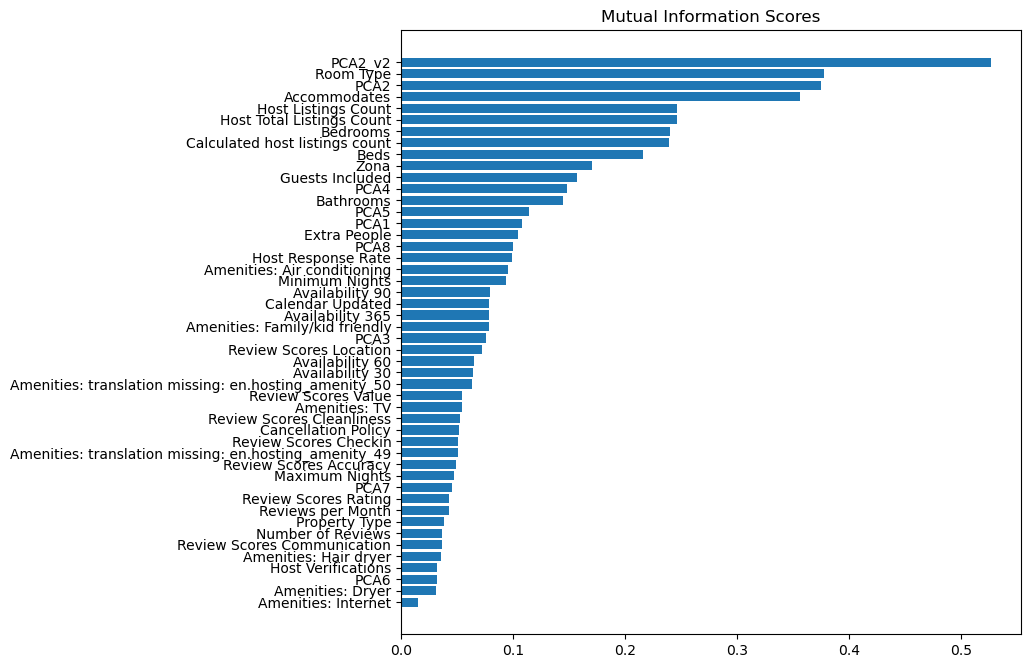

In [22]:
plt.figure(dpi=100, figsize=(8, 8))
plot_mi_scores(I_M)

Veo que la interacción que he creado es, con mucho, la variable más informativa de todo el dataset.

El motivo por el que añade información que "PCA2" no contenia es porque "PCA2" es una combinación lineal de variables, mientras que "PCA2_v2" es una interacción no lineal.

La añado también al dataset de test:

In [23]:
X_test['PCA2_v2'] = (0.4*X_test['Accommodates']+0.3*X_test['Beds'])*(0.3*X_test['Bedrooms']+0.2*X_test['Bathrooms'])*X_test['Room Type']

## Clustering: K-Means

Pruebo a aplicar el algoritmo de K-Means sobre las 8 primeras componentes principales.

Para ello, tengo que seleccionar el número de clústeres a emplear:

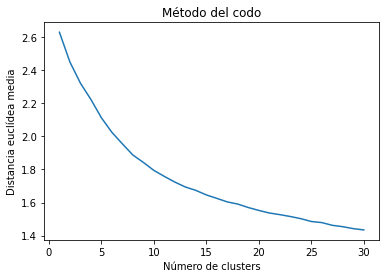

In [24]:
scaler = StandardScaler()
scaler.fit(P_comp)
X = scaler.transform(P_comp)

# Voy a determinar el número óptimo de clusters para k-means.

distancia_media = []

for i in range(1, 31):
    distancia_media.append(kmeans(obs = X, k_or_guess = i)[-1])
    
# Muestro los resultados en un gráfico para determinar un codo.
plt.plot(range(1, 31), distancia_media)
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Distancia euclídea media')
plt.show()

No está claro cuál es el número óptimo de clusters. Repito el mismo gráfico, pero esta vez sólo empleo sólo las 4 componentes principales con mayor Mutual Information, que son 'PCA2', 'PCA4', 'PCA5' y 'PCA1':

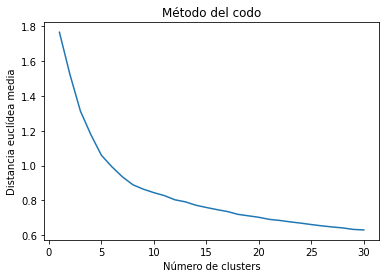

In [25]:
scaler = StandardScaler()
scaler.fit(P_comp.loc[:,['PCA2', 'PCA4', 'PCA5', 'PCA1']])
X = scaler.transform(P_comp.loc[:,['PCA2', 'PCA4', 'PCA5', 'PCA1']])

# Voy a determinar el número óptimo de clusters para k-means.

distancia_media = []

for i in range(1, 31):
    distancia_media.append(kmeans(obs = X, k_or_guess = i)[-1])
    
# Muestro los resultados en un gráfico para determinar un codo.
plt.plot(range(1, 31), distancia_media)
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Distancia euclídea media')
plt.show()

El número de clústers a seleccionar esta más claro en este gráfico. Selecciono 8 clúteres:

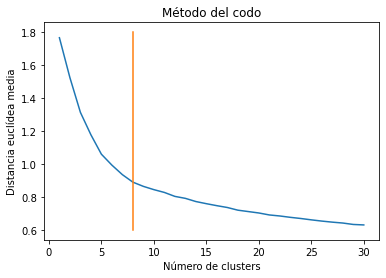

In [26]:
plt.plot(range(1, 31), distancia_media)
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Distancia euclídea media')
plt.plot((8, 8), (0.6, 1.8))
plt.show()

Repito el gráfico, acercándolo más para mayor claridad:

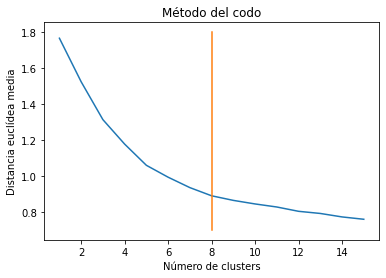

In [27]:
plt.plot(range(1, 16), distancia_media[0:15])
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Distancia euclídea media')
plt.plot((8, 8), (0.7, 1.8))
plt.show()

Calculo los centroides, y la media de las distancias euclídeas de las observaciones a los centroides:

In [28]:
Centroides, Media_de_distancias = kmeans(obs = X, k_or_guess = 8)

Calculo que clúster le corresponde a cada observación, y la distancia de cada observación a su clúster correspondiente.

In [29]:
clusters, distancias = vq(X, Centroides)

Creo las nuevas variables 'Cluster', con el clúster correspondiente a cada observación, y 'Distancia al centroide', con la distancia de cada observación a su clúster correspondiente:

In [30]:
X_train['Cluster'] = clusters
X_train['Distancia al centroide'] = distancias

Calculo la información mutua de las variables, para ver si las nuevas variables son informativas:

In [31]:
I_M = Información_Mutua(X_train, y_train)
I_M[::]

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PCA2_v2                                                  0.531067
Room Type                                                0.382158
PCA2                                                     0.374364
Accommodates                                             0.360310
Cluster                                                  0.289089
Host Listings Count                                      0.243437
Bedrooms                                                 0.242503
Host Total Listings Count                                0.240644
Calculated host listings count                           0.228397
Beds                                                     0.223030
Guests Included                                          0.165103
Zona                                                     0.163700
PCA4                                                     0.150298
Bathrooms                                                0.135074
PCA5                                                     0.117674
PCA1      

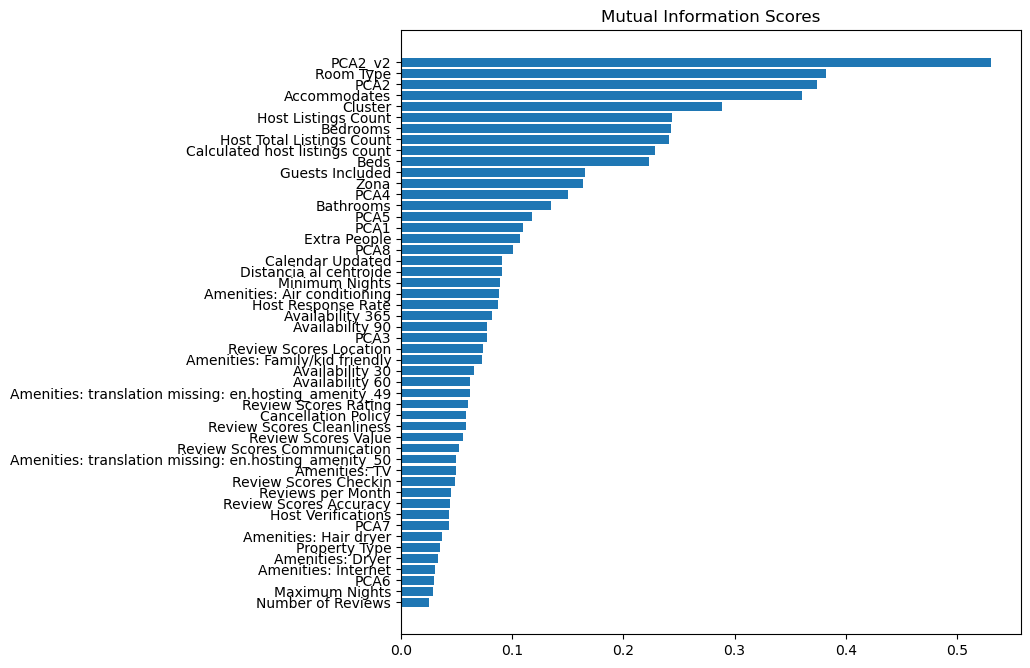

In [32]:
plt.figure(dpi=100, figsize=(8, 8))
plot_mi_scores(I_M)

Veo que la variable 'Clúster' es muy informativa, de hecho, es la quinta variable más informativa.

Lo que es más, de las cinco variables más informativas, tres de ellas han sido creadas en este Notebook ("PCA2_v2", "PCA2" y "Clúster").

Creo estas dos nuevas variables ("Clúster" y "Distancias al centroide") en el dataset de test, con los modelos entrenados en el dataset de train:

In [33]:
X = scaler.transform(P_comp_test.loc[:,['PCA2', 'PCA4', 'PCA5', 'PCA1']])
clusters, distancias = vq(X, Centroides)
X_test['Cluster'] = clusters
X_test['Distancia al centroide'] = distancias

## Escalado de variables

Por claridad en los Notebooks futuros, ordenos las variables dentro de los datasets por su información mutua:

In [34]:
list(I_M.index)

['PCA2_v2',
 'Room Type',
 'PCA2',
 'Accommodates',
 'Cluster',
 'Host Listings Count',
 'Bedrooms',
 'Host Total Listings Count',
 'Calculated host listings count',
 'Beds',
 'Guests Included',
 'Zona',
 'PCA4',
 'Bathrooms',
 'PCA5',
 'PCA1',
 'Extra People',
 'PCA8',
 'Calendar Updated',
 'Distancia al centroide',
 'Minimum Nights',
 'Amenities: Air conditioning',
 'Host Response Rate',
 'Availability 365',
 'Availability 90',
 'PCA3',
 'Review Scores Location',
 'Amenities: Family/kid friendly',
 'Availability 30',
 'Availability 60',
 'Amenities: translation missing: en.hosting_amenity_49',
 'Review Scores Rating',
 'Cancellation Policy',
 'Review Scores Cleanliness',
 'Review Scores Value',
 'Review Scores Communication',
 'Amenities: translation missing: en.hosting_amenity_50',
 'Amenities: TV',
 'Review Scores Checkin',
 'Reviews per Month',
 'Review Scores Accuracy',
 'Host Verifications',
 'PCA7',
 'Amenities: Hair dryer',
 'Property Type',
 'Amenities: Dryer',
 'Amenities: I

In [35]:
X_train = X_train.loc[:,list(I_M.index)]
X_test = X_test.loc[:,list(I_M.index)]

Escalo las variables de train y test (escalo test con el modelo entrenado en train) para no tener que hacer este paso en el futuro:

In [36]:
scaler = StandardScaler()
scaler.fit(X_train)
X = scaler.transform(X_train)

X_train = pd.DataFrame(X,columns = list(I_M.index))

X = scaler.transform(X_test)

X_test = pd.DataFrame(X,columns = list(I_M.index))

In [37]:
X_train.head()

,PCA2_v2,Room Type,PCA2,Accommodates,Cluster,Host Listings Count,Bedrooms,Host Total Listings Count,Calculated host listings count,Beds,...,Review Scores Accuracy,Host Verifications,PCA7,Amenities: Hair dryer,Property Type,Amenities: Dryer,Amenities: Internet,PCA6,Maximum Nights,Number of Reviews
0,0.965820,0.781988,0.399755,1.308542,0.191203,-0.338028,1.852905,-0.338025,-0.359953,1.215526,...,0.829291,-0.869753,0.002926,0.894033,0.089614,-0.488541,0.239369,0.497480,0.018603,-0.016780
1,0.918794,0.781988,1.391291,0.828961,-1.321494,-0.338028,1.852905,-0.338025,-0.359953,1.215526,...,-1.608828,-0.869753,1.273190,0.894033,0.842246,2.046911,0.239369,-1.046027,0.018603,-0.590484
2,-0.458027,-1.146993,-0.193051,-1.089363,0.695435,0.742270,-0.379882,0.742273,1.201020,-0.644884,...,-1.853730,2.242432,-0.036864,-1.118526,0.089614,-0.488541,0.239369,-1.643860,0.018603,-0.590484
3,-0.370506,0.781988,-0.679934,-0.609782,1.199668,-0.250437,-0.379882,-0.250433,-0.233387,-0.644884,...,0.829291,0.686339,2.172779,0.894033,0.089614,2.046911,0.239369,-0.989716,0.018603,-0.329709
4,-0.549467,-1.146993,-0.768827,-1.089363,0.695435,-0.338028,-1.496275,-0.338025,-0.359953,-0.644884,...,-1.644041,0.686339,0.018753,-1.118526,0.089614,2.046911,0.239369,-0.460788,-0.107586,-0.590484


In [38]:
X_test.head()

,PCA2_v2,Room Type,PCA2,Accommodates,Cluster,Host Listings Count,Bedrooms,Host Total Listings Count,Calculated host listings count,Beds,...,Review Scores Accuracy,Host Verifications,PCA7,Amenities: Hair dryer,Property Type,Amenities: Dryer,Amenities: Internet,PCA6,Maximum Nights,Number of Reviews
0,-0.494603,-1.146993,-1.054864,-1.089363,1.199668,-0.279634,-0.379882,-0.279630,-0.317764,-0.644884,...,0.169573,1.464385,0.166473,-1.118526,0.842246,-0.488541,0.239369,-1.257553,-0.107249,0.270072
1,-0.494603,-1.146993,-0.801364,-1.089363,0.695435,-0.338028,-0.379882,-0.338025,-0.359953,-0.644884,...,-1.110005,1.464385,0.660000,-1.118526,0.089614,-0.488541,0.239369,-1.015407,0.018603,-0.590484
2,-0.494603,-1.146993,-0.874377,-1.089363,-0.313029,-0.308831,-0.379882,-0.308827,-0.317764,-0.644884,...,0.829291,-0.091707,0.496182,0.894033,0.089614,-0.488541,0.239369,0.455318,0.018603,-0.486174
3,1.553647,0.781988,1.596890,1.308542,0.191203,0.800665,1.852905,0.800667,1.158832,1.835663,...,0.829291,-0.091707,0.575622,-1.118526,0.089614,2.046911,0.239369,0.744539,0.018603,0.035375
4,-0.494603,-1.146993,-1.315762,-1.089363,1.199668,-0.338028,-0.379882,-0.338025,-0.359953,-0.644884,...,0.169573,2.242432,0.567065,0.894033,0.089614,-0.488541,0.239369,-1.519531,0.018603,-0.225400


Guardo los datasets de train y test escalados y con las nuevas variables:

In [39]:
#X_train.to_csv('X_train_ns.csv')
#X_test.to_csv('X_test_ns.csv')